In [1]:
import fasr_solar_simul as fss
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1
from scipy.constants import c
import os
from casatasks import tclean
from datetime import datetime
from tqdm import tqdm

# Speed of light in m/s
C_LIGHT = c
import matplotlib
%matplotlib inline

measures_update ... acquiring the lock ... 
  ... connecting to ftp.astron.nl ...
  ... downloading WSRT_Measures_20250409-160001.ztar from ASTRON server to /Users/fisher/.casa/data ...
  ... measures data updated at /Users/fisher/.casa/data


2 GHz: first local minimum at uv distance = 16.32 m, amplitude = 2.4108e-03
Nyquist frequency: 2 GHz: 1.23 samples per 10 meters
4 GHz: first local minimum at uv distance = 9.01 m, amplitude = 7.6733e-03
Nyquist frequency: 4 GHz: 2.22 samples per 10 meters
10 GHz: first local minimum at uv distance = 3.80 m, amplitude = 9.7896e-03
Nyquist frequency: 10 GHz: 5.26 samples per 10 meters
20 GHz: first local minimum at uv distance = 2.00 m, amplitude = 3.6169e-02
Nyquist frequency: 20 GHz: 9.99 samples per 10 meters


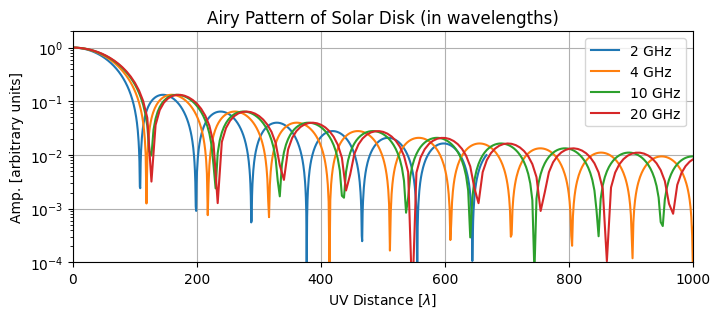

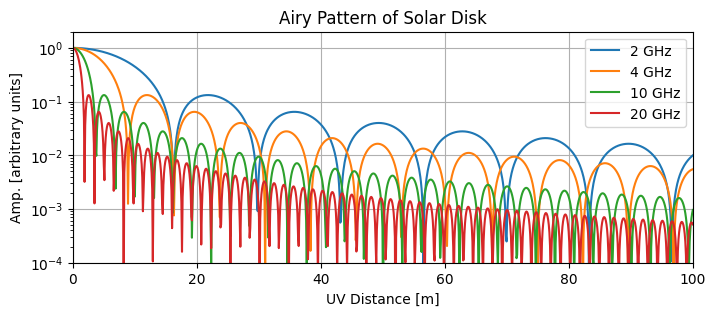

In [2]:
# Fitted parameters for disk_size_function
c1 = 4.08532216e+02
alpha1 = 1.25993061e+00
c2 = 9.91633278e+02
alpha2 = 4.59227095e-03

# Frequencies in GHz to test
frequencies = [2, 4, 10, 20]

# Range of uv distances in meters
uv_meters = np.linspace(0, 100, 1000)  # 0 to 200 m

fig0, ax0 = plt.subplots(figsize=(8, 3))
fig, ax = plt.subplots(figsize=(8, 3))

nyq_sample = {}
for freq in frequencies:
    # 1. Get disk radius in arcseconds at this frequency
    R_arcsec = fss.disk_size_function(freq, c1, alpha1, c2, alpha2)

    # 2. Convert uv distance from meters to wavelengths
    freq_hz = freq * 1e9
    wavelength_m = C_LIGHT / freq_hz
    s_wavelengths = uv_meters / wavelength_m

    # 3. Compute Airy amplitude
    amplitude = fss.airy_model(R_arcsec, s_wavelengths, A=1.0)
    abs_amp = np.abs(amplitude)

    # 4. Plot amplitude vs uv distance in meters
    ax0.plot(s_wavelengths, abs_amp, label=f"{freq} GHz")
    ax.plot(uv_meters, abs_amp, label=f"{freq} GHz")

    # 5. Find the first local minimum using np.gradient
    grad = np.gradient(abs_amp)
    # Find indices where the gradient changes from negative to non-negative:
    crossings = np.where((grad[:-1] < 0) & (grad[1:] >= 0))[0]

    if crossings.size > 0:
        local_min_index = crossings[0] + 1  # offset by 1 because of diff
        nyq_sample[f'{freq} GHz'] = 2 * 10 / uv_meters[local_min_index]
        print(
            f"{freq} GHz: first local minimum at uv distance = {uv_meters[local_min_index]:.2f} m, amplitude = {abs_amp[local_min_index]:.4e}")
        print(f'Nyquist frequency: {freq} GHz: {2 * 10 / uv_meters[local_min_index]:.2f} samples per 10 meters')
    else:
        print(f"{freq} GHz: no local minimum found in the given range.")

ax0.set_xlabel(r"UV Distance [${\lambda}$]")
ax0.set_ylabel("Amp. [arbitrary units]")
ax0.set_title("Airy Pattern of Solar Disk (in wavelengths)")
ax0.set_yscale('log')
ax0.legend()
ax0.grid(True)
ax0.set_ylim(1e-4, 2)
ax0.set_xlim(0, 1000)

ax.set_xlabel("UV Distance [m]")
ax.set_ylabel("Amp. [arbitrary units]")
ax.set_title("Airy Pattern of Solar Disk")
ax.set_yscale('log')
ax.legend()
ax.set_xlim(0, 100)
ax.set_ylim(1e-4, 2)
ax.grid(True)


In [67]:
from importlib import reload
reload(fss)

<module 'fasr_solar_simul' from '/Users/fisher/Library/Mobile Documents/com~apple~CloudDocs/work/research_project/ipynb_scripts_local/fasr_solar_simul.py'>

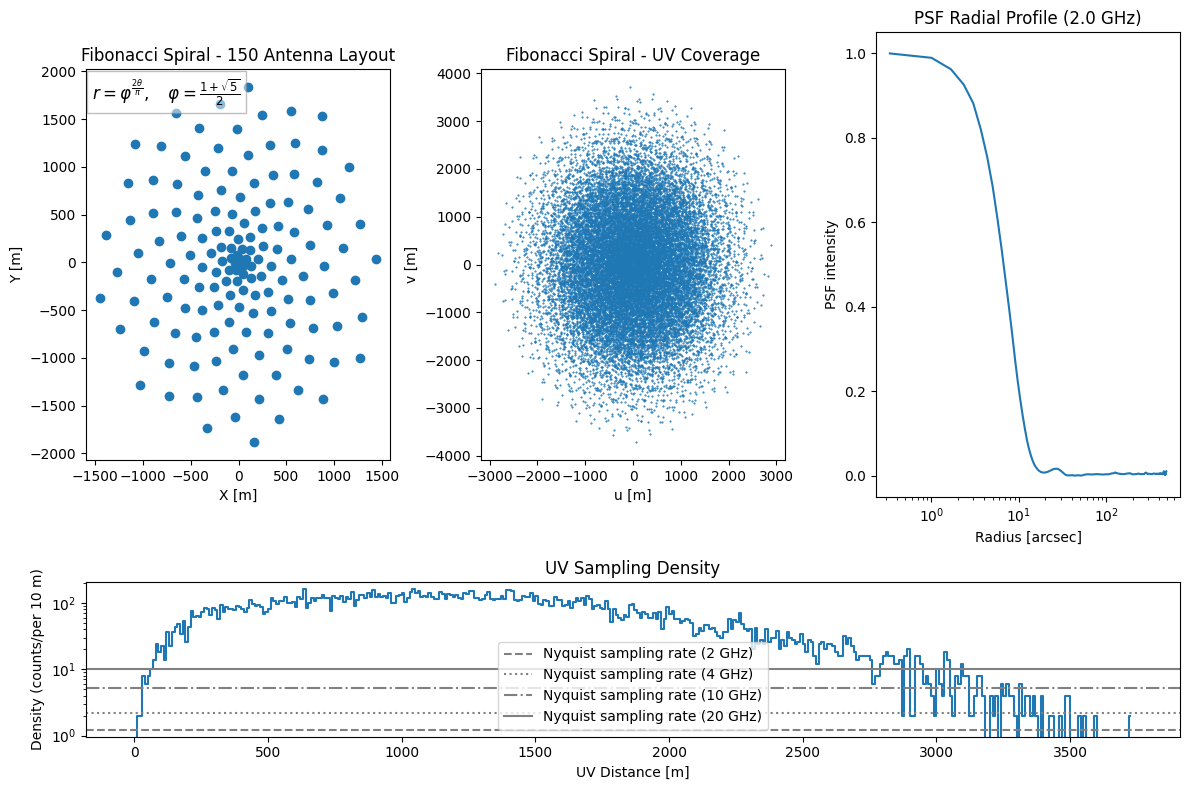

In [68]:
positions_fib = fss.generate_fibonacci_spiral_antenna_positions(n_antennas=150, scale=10)
fss.plot_all_panels(positions_fib, "Fibonacci Spiral", nyq_sample=nyq_sample, psf_mode='profile')

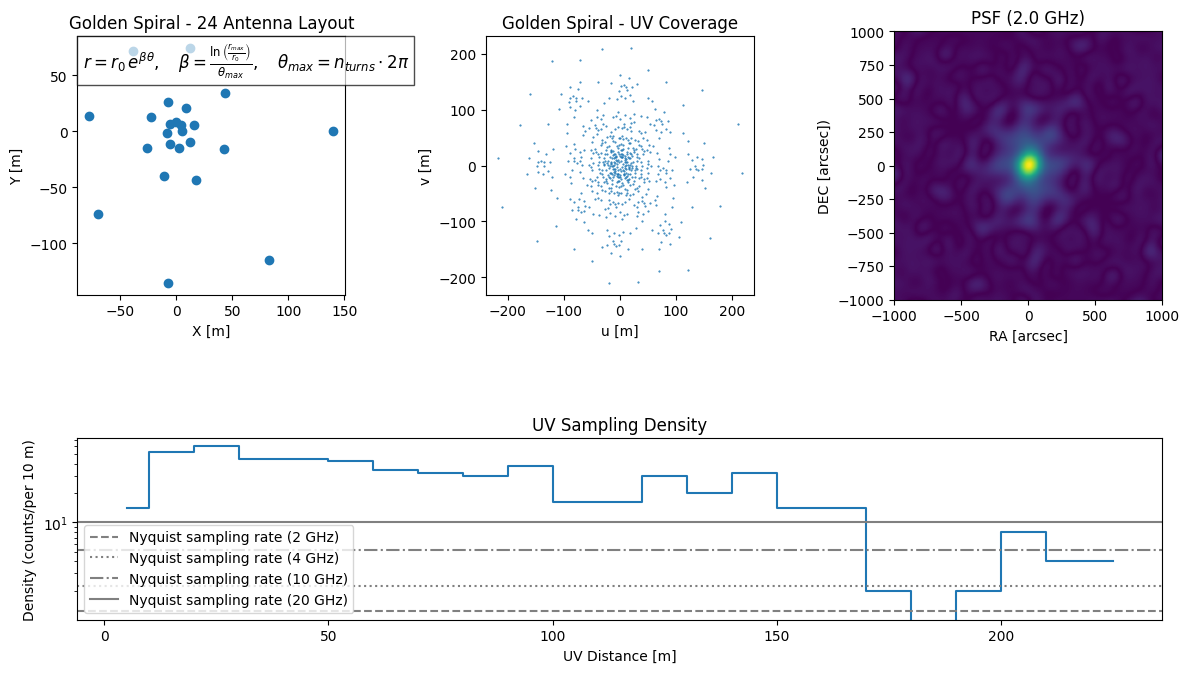

In [4]:
positions_nautilus = fss.generate_golden_spiral_antenna_positions(n_antennas=24, r0=5, r_max=140, n_turns=3)
fss.plot_all_panels(positions_nautilus, "Golden Spiral", nyq_sample=nyq_sample)

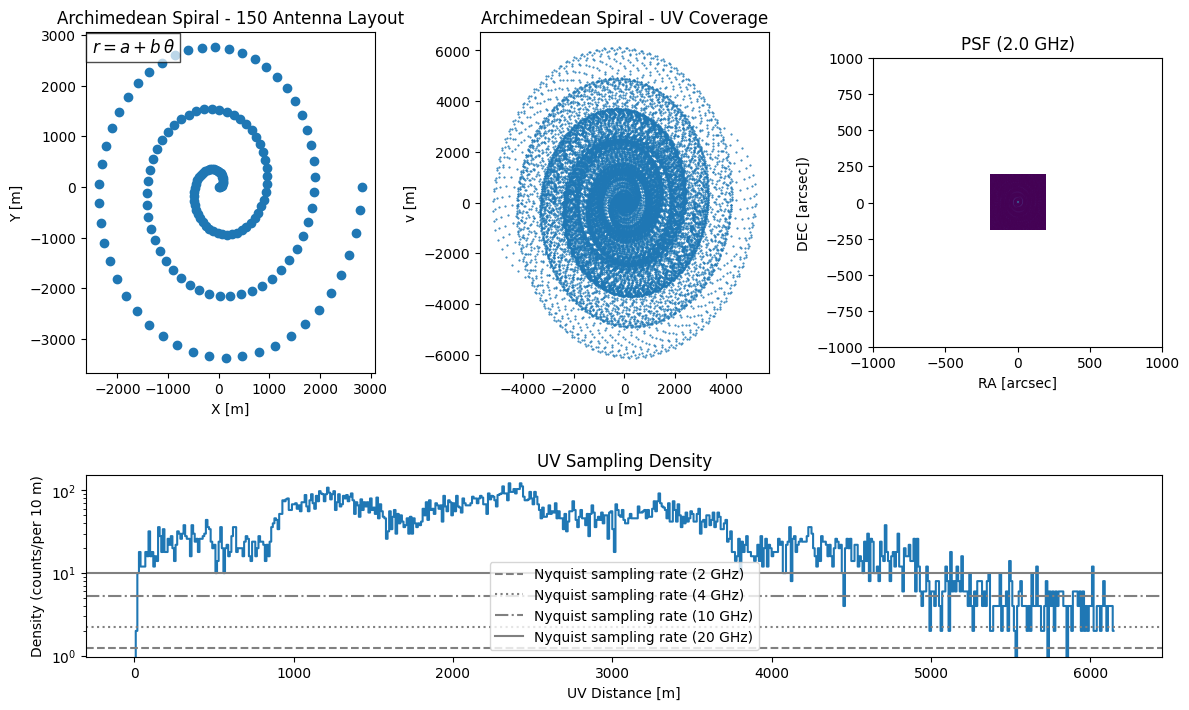

In [5]:
positions_arch = fss.generate_archimedean_spiral_antenna_positions(n_antennas=150, a=1, b=150, theta_max=6 * np.pi)
fss.plot_all_panels(positions_arch, "Archimedean Spiral", nyq_sample=nyq_sample)

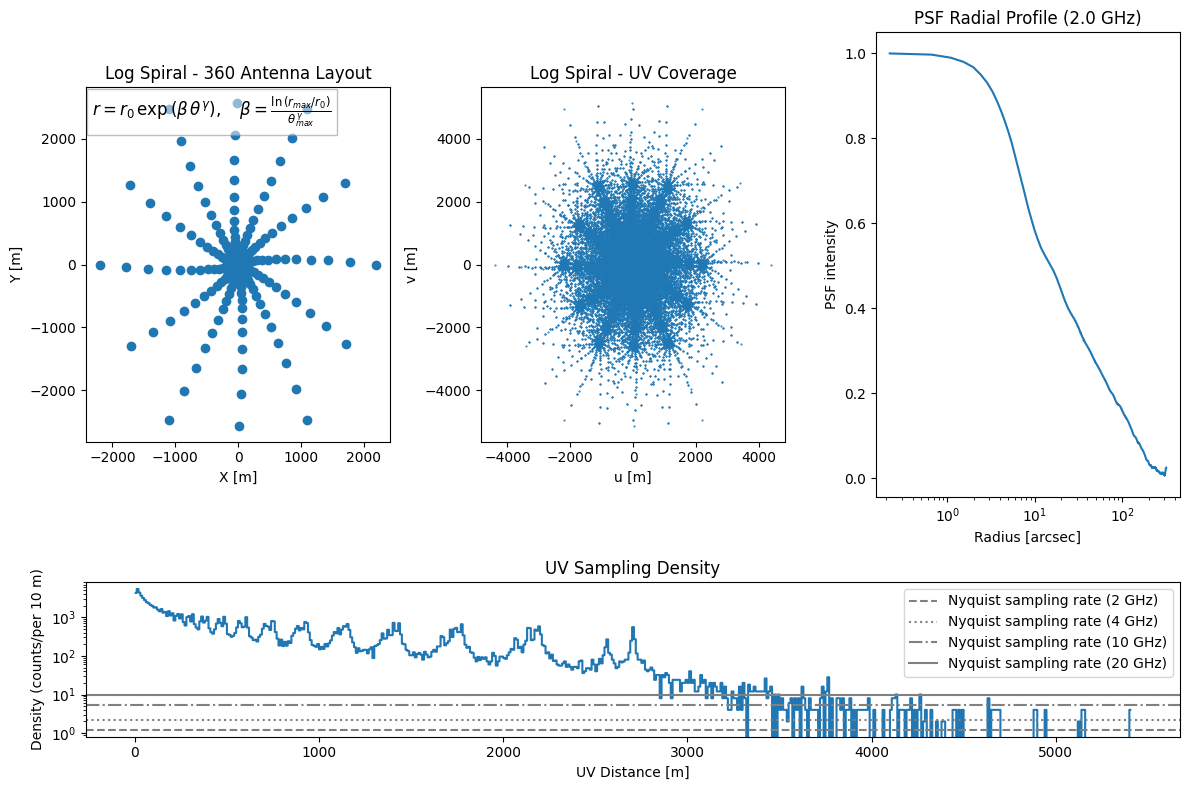

In [69]:
%matplotlib inline
from importlib import reload

reload(fss)
positions_logspiral = fss.generate_log_spiral_antenna_positions(n_arms=6, antennas_per_arm=60, alpha=1., gamma=0.9,
                                                                r0=2., r_max=2200, n_turn=5)
fss.plot_all_panels(positions_logspiral, "Log Spiral", frequency=2, nyq_sample=nyq_sample)
# fig = plt.gcf()
# ax = fig.axes[0]
# ax.set_xlim(-50,50)
# ax.set_ylim(-50,50)

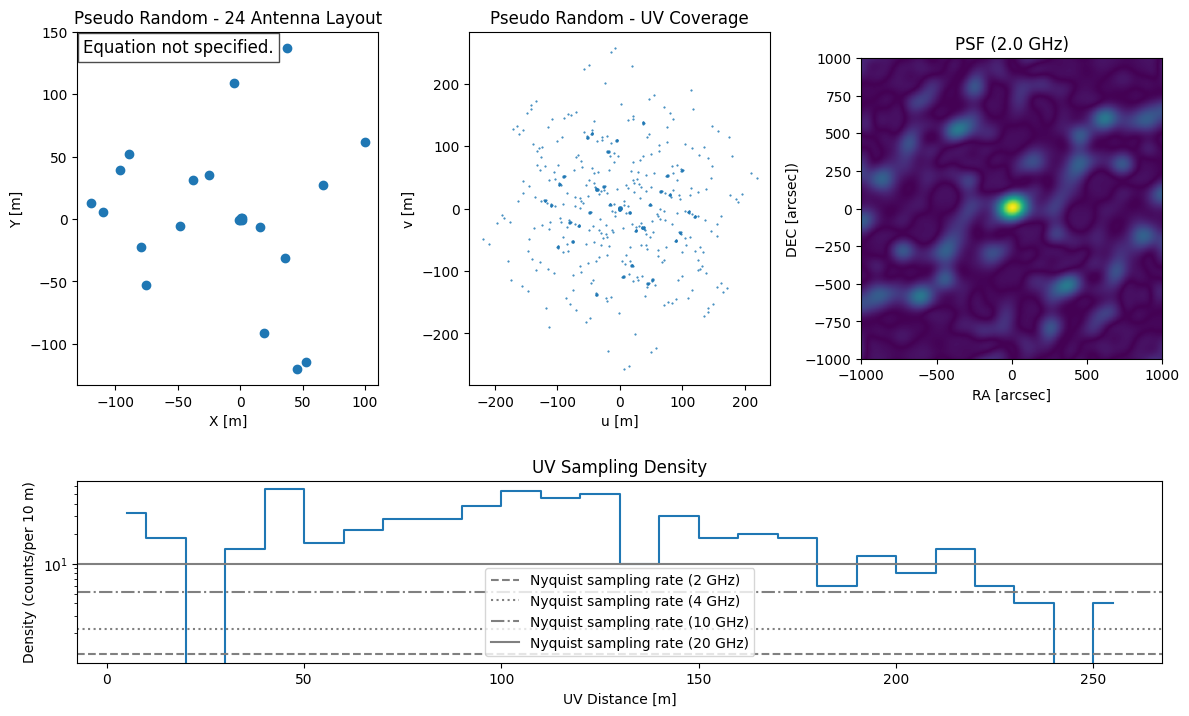

In [533]:
%matplotlib inline
positions_pseudo = fss.generate_pseudorandom_disk_antenna_positions(n_antennas=24, radius=150, n_edge=0,
                                                                    cluster_antennas=6,
                                                                    cluster_radius=1.5)
fss.plot_all_panels(positions_pseudo, "Pseudo Random", nyq_sample=nyq_sample)

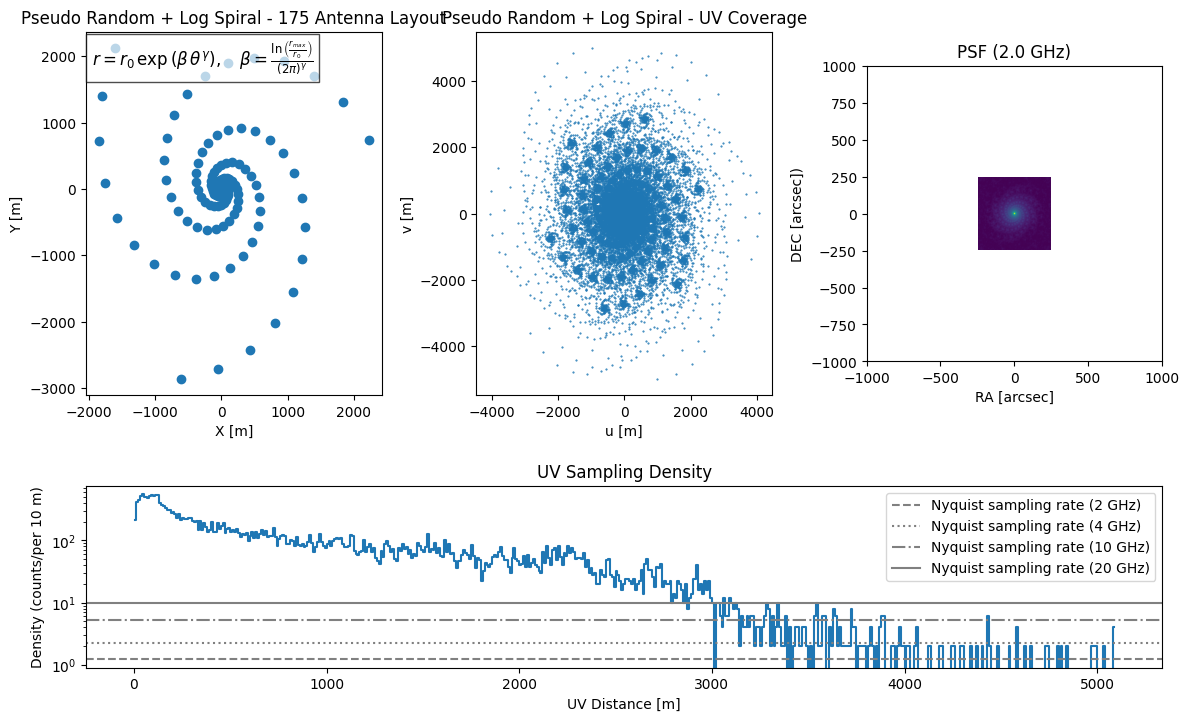

In [534]:
positions_comb = np.concatenate([positions_pseudo, positions_logspiral], 0)
fss.plot_all_panels(positions_comb, "Pseudo Random + Log Spiral", nyq_sample=nyq_sample)

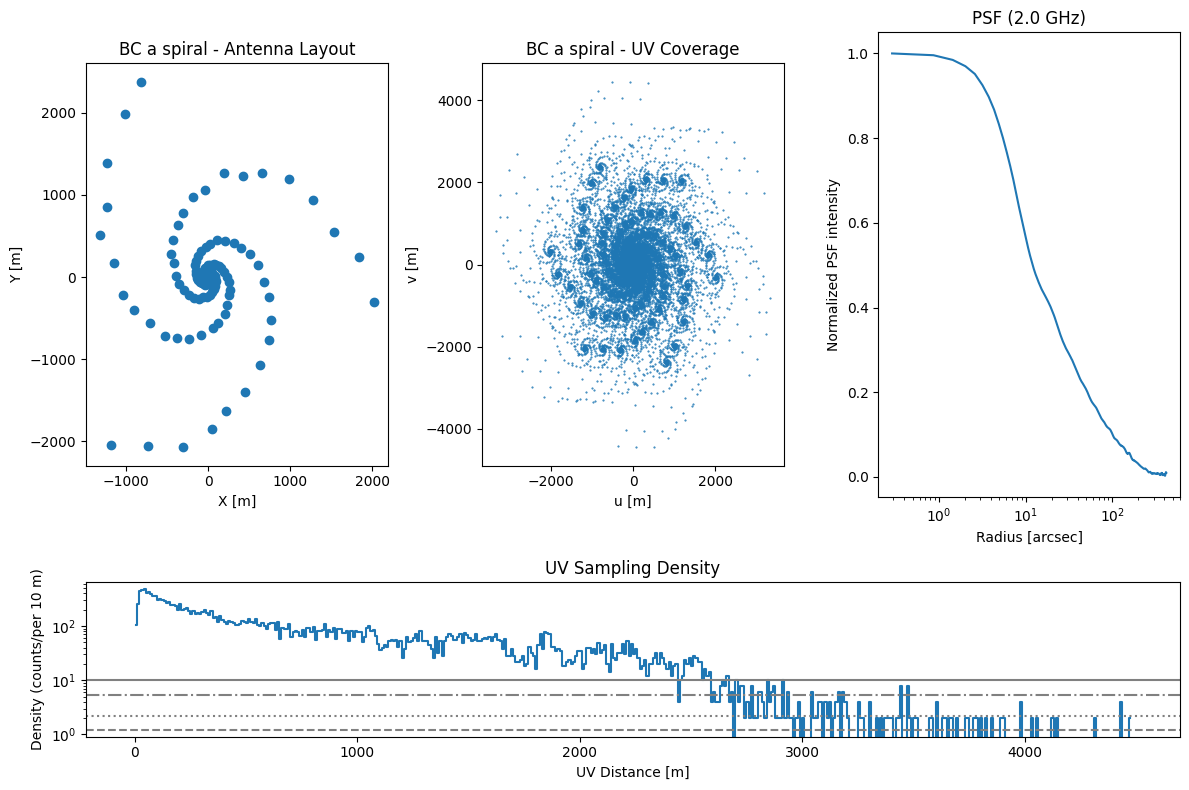

In [79]:
from importlib import reload

reload(fss)
positions_bc, _ = fss.read_casa_antenna_list('fasr-a-spiral-150.cfg')
fss.plot_all_panels(positions_bc, "BC a spiral", nyq_sample=nyq_sample)

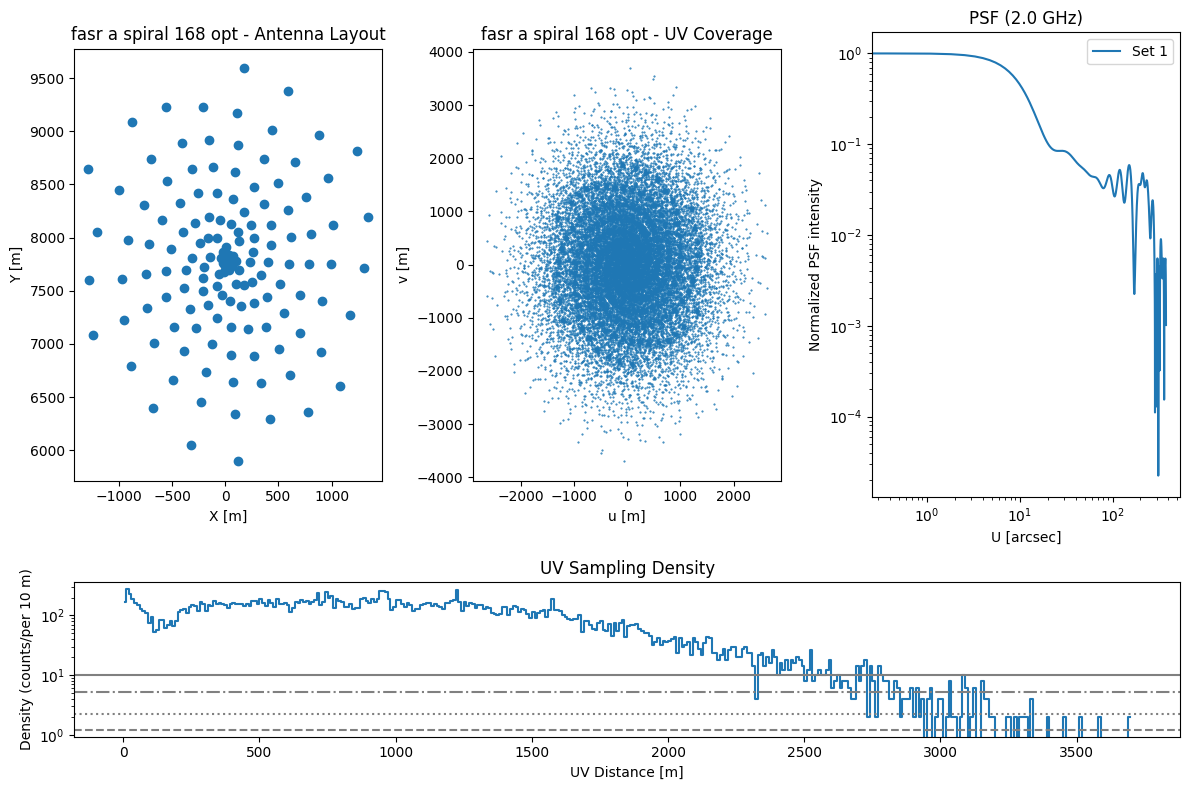

In [90]:
from importlib import reload

reload(fss)
positions_bc_opt, _ = fss.read_casa_antenna_list('fasr-a-spiral-168-opt.cfg')
fss.plot_all_panels(positions_bc_opt, "fasr a spiral 168 opt", nyq_sample=nyq_sample)

fig saved to fig-fasr_Log_Spiral-168-n_arms=3-antennas_per_arm=56-alpha=1.00-gamma=0.55-r0=1.5-r_max=1800-n_turn=2.0.jpg


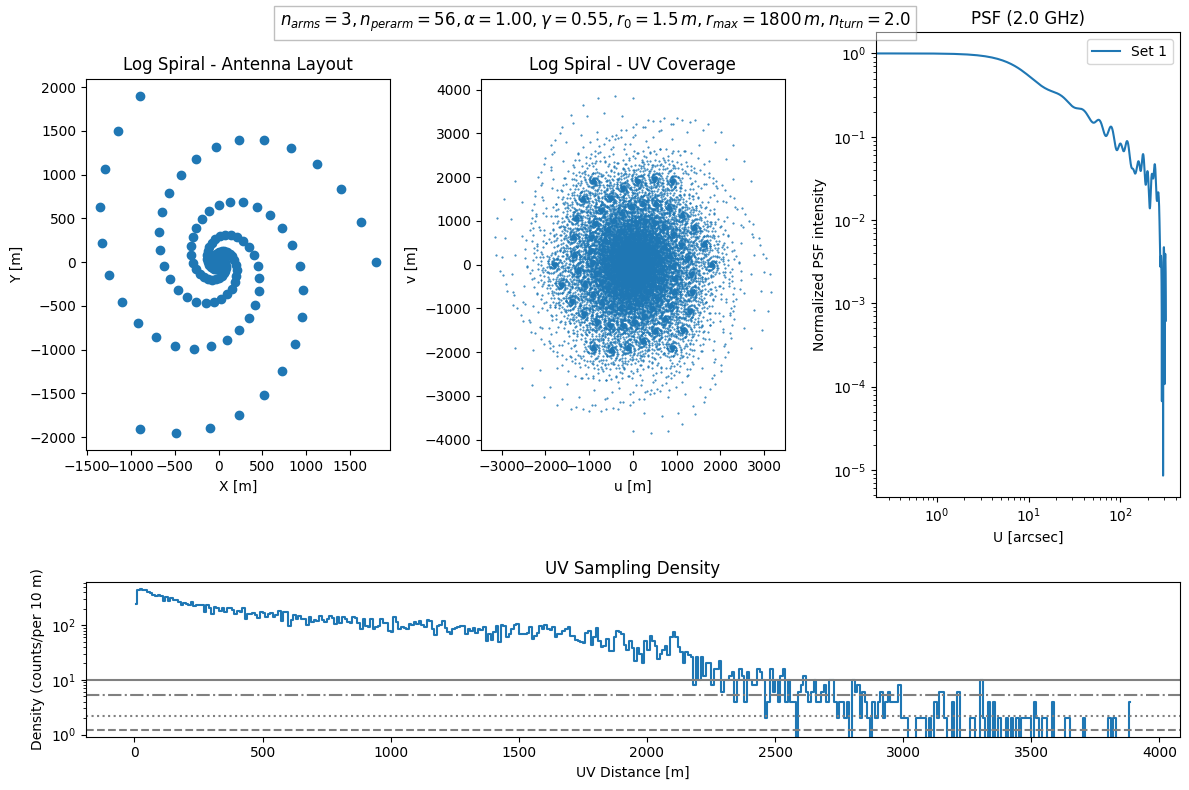

In [89]:
# %matplotlib notebook
%matplotlib inline
from importlib import reload

reload(fss)
# positions_logspiral = fss.generate_log_spiral_antenna_positions(n_arms=3, antennas_per_arm=50, alpha=2.05, gamma=0.9,
#                                                                 r0=2., r_max=2300)
# positions_logspiral = fss.generate_log_spiral_antenna_positions(n_arms=3, antennas_per_arm=50, alpha=1., gamma=0.7,
#                                                                 r0=2.5, r_max=2000, n_turn=1.71)
# positions_logspiral = fss.generate_log_spiral_antenna_positions(n_arms=3, antennas_per_arm=50, alpha=1., gamma=0.6,
#                                                                 r0=2, r_max=2100, n_turn=1.71)
# positions_logspiral = fss.generate_log_spiral_antenna_positions(n_arms=3, antennas_per_arm=50, alpha=1., gamma=0.5,
#                                                                 r0=1.5, r_max=2200, n_turn=1.4, latitude=35)
# positions_logspiral = fss.generate_log_spiral_antenna_positions(n_arms=3, antennas_per_arm=100, alpha=1., gamma=0.9,
#                                                                 r0=1.2, r_max=2300, n_turn=2., latitude=35)
# positions_logspiral = fss.generate_log_spiral_antenna_positions(n_arms=3, antennas_per_arm=56, alpha=1., gamma=0.5,
#                                                                 r0=1.5, r_max=2000, n_turn=1.4, latitude=35)
array_config = {"n_arms": 3, "antennas_per_arm": 56, "alpha": 1.0, "gamma": 0.55, "r0": 1.5, "r_max": 1800, "n_turn": 2,
                "latitude": 35}

# for gam in np.linspace(0.3, 1, 8):
# array_config = {"n_arms": 3, "antennas_per_arm": 56, "alpha": 1.0, "gamma": gam, "r0": 1.5, "r_max": 1800, "n_turn": 2,
#                 "latitude": 35}
positions_logspiral = fss.generate_log_spiral_antenna_positions(**array_config)
figname = (
    f"fig-fasr_Log_Spiral-{len(positions_logspiral)}-"
    f"n_arms={array_config['n_arms']}-antennas_per_arm={array_config['antennas_per_arm']}-"
    f"alpha={array_config['alpha']:.2f}-gamma={array_config['gamma']:.2f}-"
    f"r0={array_config['r0']:.1f}-r_max={array_config['r_max']:.0f}-n_turn={array_config['n_turn']:.1f}.jpg")
print(f'fig saved to {figname}')
figsubfolder = figname.rstrip('.jpg')
formatted_params = [
    rf"$n_{{\rm arms}}={array_config['n_arms']}$",
    rf"$\mbox{{antennas per arm}}={array_config['antennas_per_arm']}$",
    rf"$\alpha={array_config['alpha']:.2f}$",
    rf"$\gamma={array_config['gamma']:.2f}$",
    rf"$r_0={array_config['r0']:.1f}\,\mbox{{m}}$",
    rf"$r_{{\rm max}}={array_config['r_max']:.0f}\,\mbox{{m}}$",
    rf"$n_{{\rm turn}}={array_config['n_turn']:.1f}$"
]

# Create a full string that also includes the spiral equation.
array_config_str = (
    rf"$n_{{arms}}={array_config['n_arms']}, "
    rf"n_{{perarm}}={array_config['antennas_per_arm']}, "
    rf"\alpha={array_config['alpha']:.2f}, \gamma={array_config['gamma']:.2f}, "
    rf"r_0={array_config['r0']:.1f}\,m, r_{{max}}={array_config['r_max']:.0f}\,m, "
    rf"n_{{turn}}={array_config['n_turn']:.1f}$"
)
fss.plot_all_panels(positions_logspiral, "Log Spiral", frequency=2, nyq_sample=nyq_sample, figname=figname, array_config_str = array_config_str)
# fig = plt.gcf()
# ax = fig.axes[0]
# ax.set_xlim(-10,10)
# ax.set_ylim(-10,10)

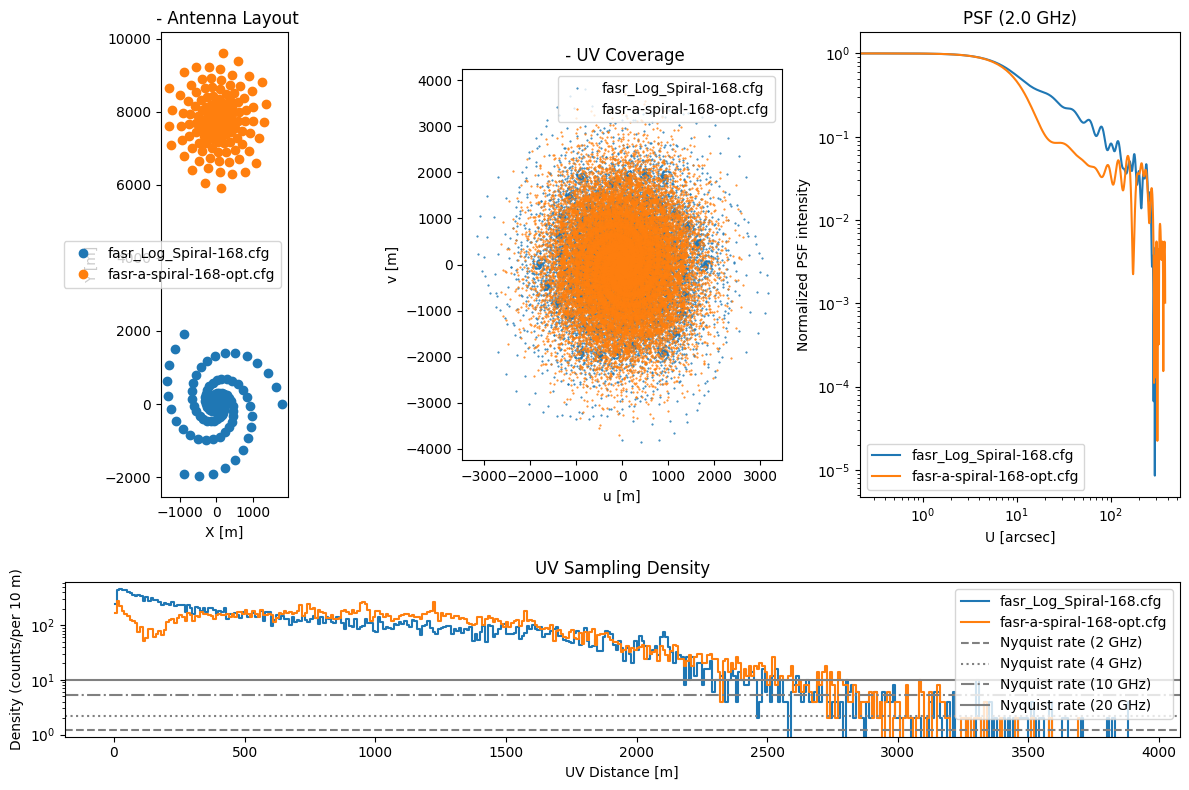

In [92]:
%matplotlib inline
from importlib import reload

reload(fss)
fss.plot_all_panels([positions_logspiral, positions_bc_opt],
                    labels=["fasr_Log_Spiral-168.cfg", 'fasr-a-spiral-168-opt.cfg'], frequency=2, nyq_sample=nyq_sample, psf_mode='uprofile')

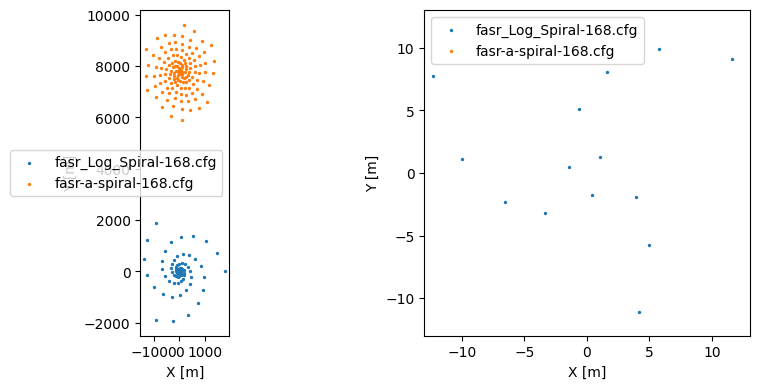

In [42]:
%matplotlib inline
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax = axs[0]
ax.scatter(positions_logspiral[:, 0], positions_logspiral[:, 1], s=2, label="fasr_Log_Spiral-168.cfg")
ax.scatter(positions_bc_opt[:, 0], positions_bc_opt[:, 1], s=2, label='fasr-a-spiral-168.cfg')
ax = axs[1]
ax.scatter(positions_logspiral[:, 0], positions_logspiral[:, 1], s=2, label="fasr_Log_Spiral-168.cfg")
ax.scatter(positions_bc_opt[:, 0], positions_bc_opt[:, 1], s=2, label='fasr-a-spiral-168.cfg')
ax.set_xlim(-13, 13)
ax.set_ylim(-13, 13)
for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.legend()
fig.tight_layout()


In [979]:
from importlib import reload

reload(fss)

<module 'fasr_solar_simul' from '/Users/fisher/Library/Mobile Documents/com~apple~CloudDocs/work/research_project/ipynb_scripts_local/fasr_solar_simul.py'>

In [39]:
# antennalist = "fasr_antenna_list_Pseudo_Random.cfg"
# os.system('rm -rf ' + antennalist)
# fss.write_casa_antenna_list(antennalist, positions_pseudo)
antennalist = f"fasr_Log_Spiral-{len(positions_logspiral)}.cfg"
os.system('rm -rf ' + antennalist)
fss.write_casa_antenna_list(antennalist, positions_logspiral)
# antennalist = "fasr_logspiral_pseudo_random.cfg"
# os.system('rm -rf ' + antennalist)
# write_casa_antenna_list(antennalist, positions_comb)
# antennalist = "fasr_antenna_list_Fib.cfg"
# os.system('rm -rf ' + antennalist)
# write_casa_antenna_list(antennalist, positions_fib)

Wrote fasr_Log_Spiral-102.cfg


In [763]:
if 0:
    import plotly.graph_objects as go
    import numpy as np
    from IPython.display import display

    # Create figure
    fig = go.Figure()

    for config_f in ['fasr-a-spiral-150.cfg', "fasr_Log_Spiral-151.cfg"]:
        antenna_params = np.genfromtxt(config_f, comments='#')
        x = antenna_params[:, 0]
        y = antenna_params[:, 1]
        z = antenna_params[:, 2]
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2),
                                   name=config_f
                                   ))

    fig.update_layout(
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        # title="Geocentric Coordinates on a Sphere"
    )

    display(fig)



Extracted from FITS header:
Frequency = 2GHz
Source RA = 4.238093 rad, DEC = -0.368072 rad
Updated FASR/solar_disk_model_20201126.2GHz.fits: CRVAL3 and RESTFRQ set to 2000000000.0 Hz
Simulation complete. Measurement set generated: FASR/fasr_2GHz_20201126T200000UT_1s_fasr_Log_Spiral-102.ms


2025-04-09 20:08:09	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Did not get the position of FASR from data repository
2025-04-09 20:08:09	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Please contact CASA to add it to the repository.
2025-04-09 20:08:09	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Using first antenna position as refence 


Extracted from FITS header:
Frequency = 4GHz
Source RA = 4.238093 rad, DEC = -0.368072 rad
Updated FASR/solar_disk_model_20201126.4GHz.fits: CRVAL3 and RESTFRQ set to 4000000000.0 Hz
Simulation complete. Measurement set generated: FASR/fasr_4GHz_20201126T200000UT_1s_fasr_Log_Spiral-102.ms


2025-04-09 20:08:52	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Did not get the position of FASR from data repository
2025-04-09 20:08:52	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Please contact CASA to add it to the repository.
2025-04-09 20:08:52	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Using first antenna position as refence 


Extracted from FITS header:
Frequency = 8GHz
Source RA = 4.238083 rad, DEC = -0.368108 rad
Updated FASR/solar_disk_model_20201126.8GHz.fits: CRVAL3 and RESTFRQ set to 8000000000.0 Hz
Simulation complete. Measurement set generated: FASR/fasr_8GHz_20201126T200000UT_1s_fasr_Log_Spiral-102.ms


2025-04-09 20:09:31	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Did not get the position of FASR from data repository
2025-04-09 20:09:31	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Please contact CASA to add it to the repository.
2025-04-09 20:09:31	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Using first antenna position as refence 


Extracted from FITS header:
Frequency = 10GHz
Source RA = 4.238093 rad, DEC = -0.368072 rad
Updated FASR/solar_disk_model_20201126.10GHz.fits: CRVAL3 and RESTFRQ set to 10000000000.0 Hz
Simulation complete. Measurement set generated: FASR/fasr_10GHz_20201126T200000UT_1s_fasr_Log_Spiral-102.ms


2025-04-09 20:10:11	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Did not get the position of FASR from data repository
2025-04-09 20:10:11	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Please contact CASA to add it to the repository.
2025-04-09 20:10:11	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Using first antenna position as refence 


Extracted from FITS header:
Frequency = 20GHz
Source RA = 4.238093 rad, DEC = -0.368072 rad
Updated FASR/solar_disk_model_20201126.20GHz.fits: CRVAL3 and RESTFRQ set to 20000000000.0 Hz
Simulation complete. Measurement set generated: FASR/fasr_20GHz_20201126T200000UT_1s_fasr_Log_Spiral-102.ms


2025-04-09 20:10:48	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Did not get the position of FASR from data repository
2025-04-09 20:10:48	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Please contact CASA to add it to the repository.
2025-04-09 20:10:48	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Using first antenna position as refence 


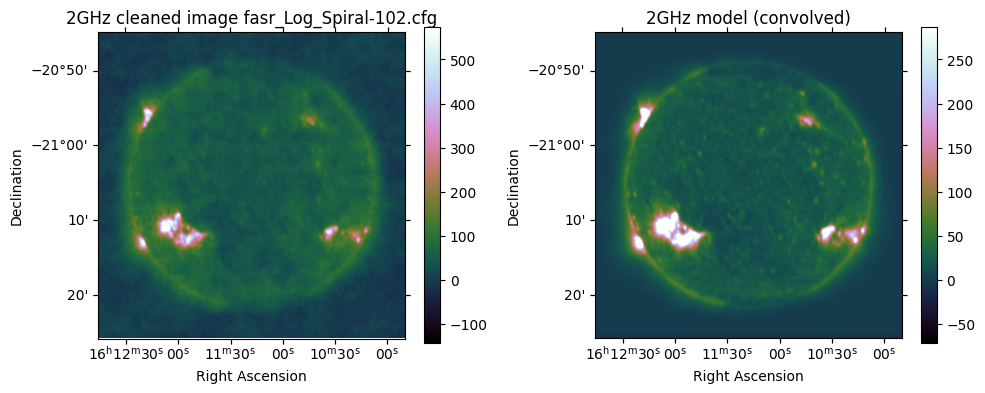

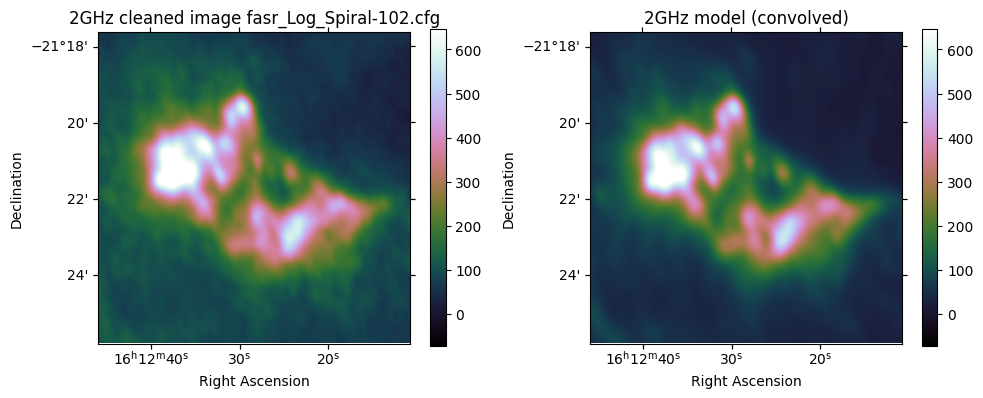

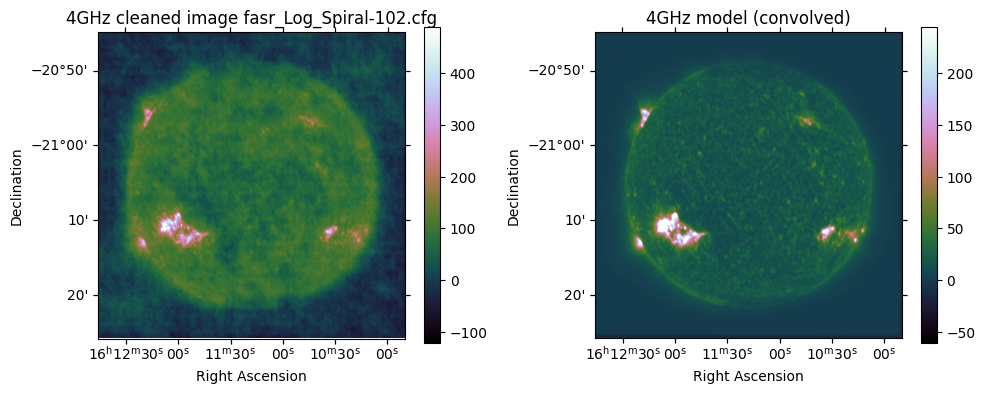

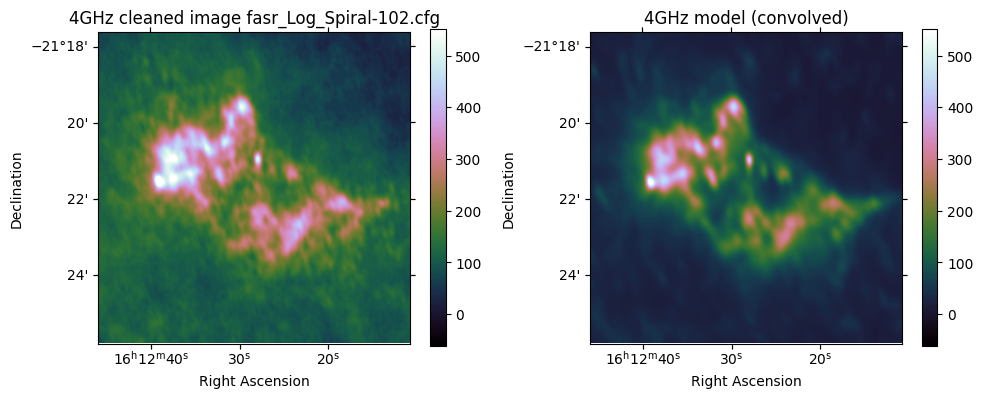

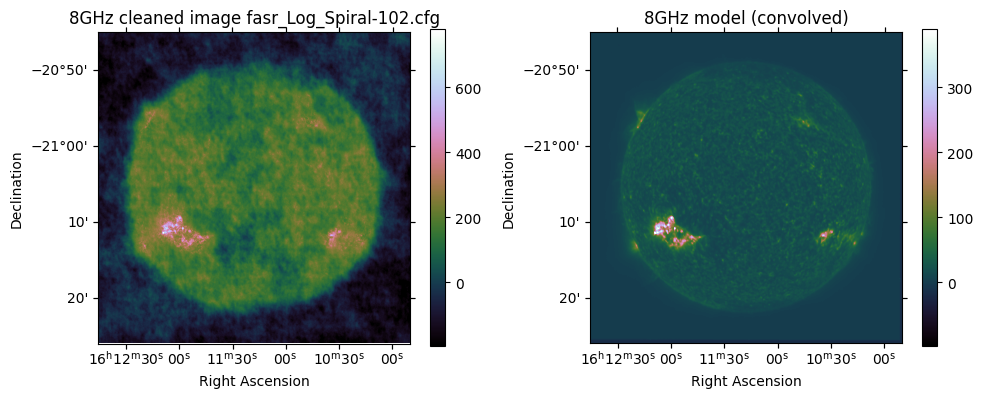

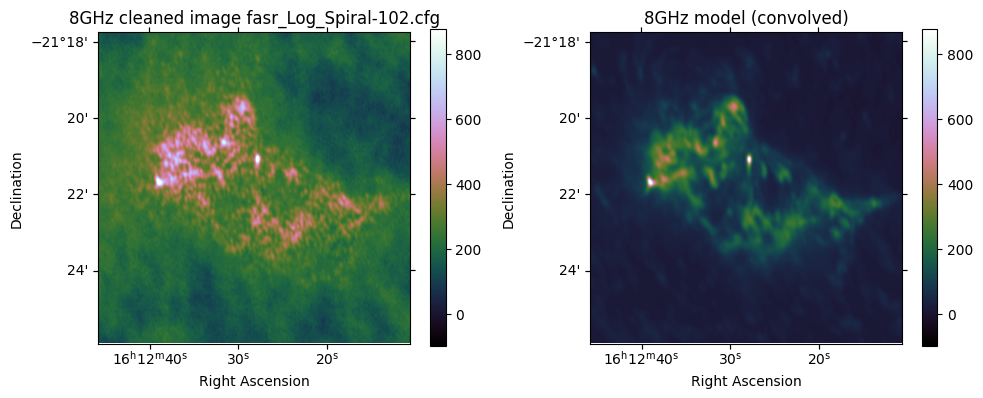

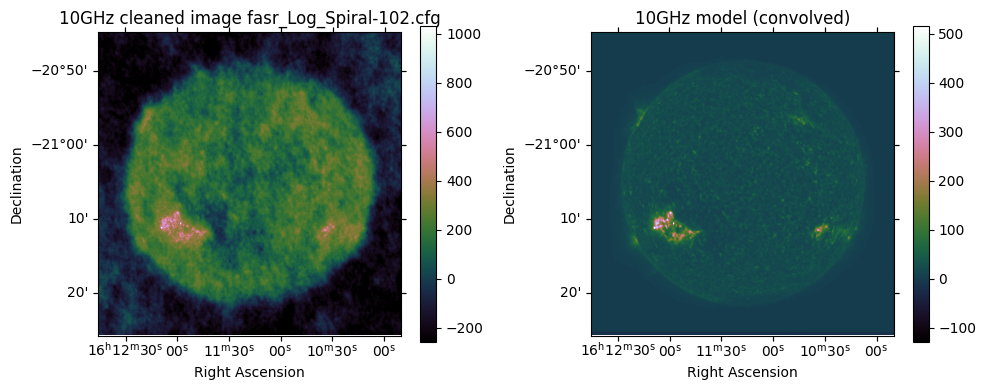

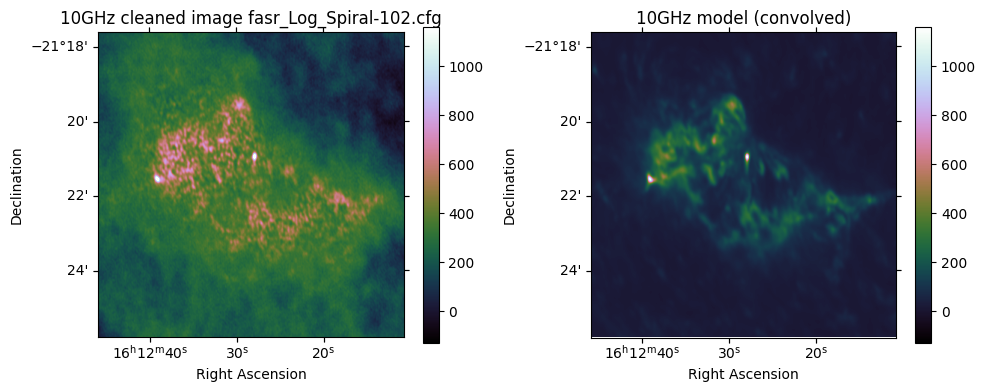

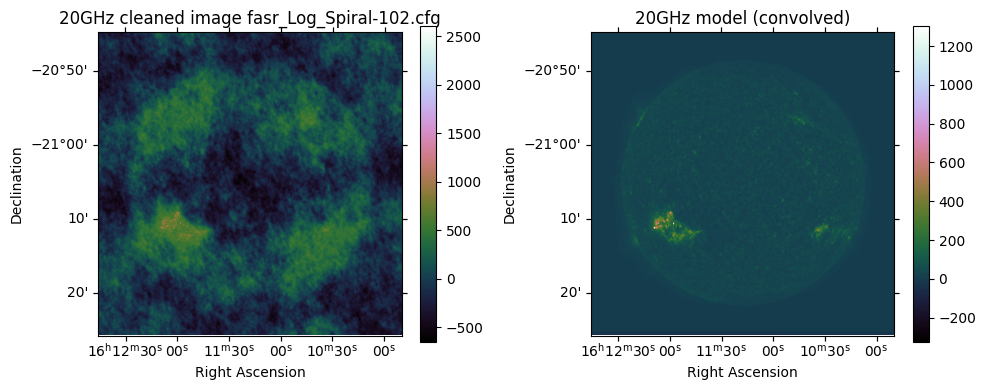

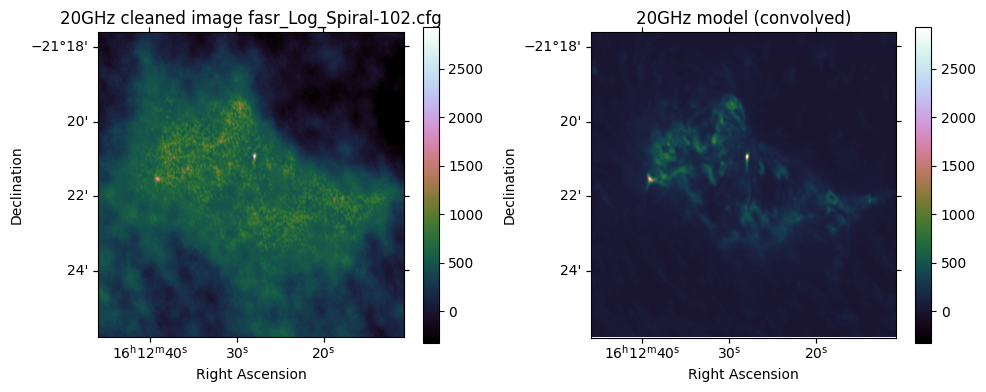

In [43]:
%matplotlib inline
# config_file = 'fasr_logspiral_pseudo_random.cfg'
config_file = 'fasr_Log_Spiral-151.cfg'
config_file = 'fasr_Log_Spiral-168.cfg'
config_file = 'fasr_Log_Spiral-102.cfg'
# config_file = 'fasr-a-spiral-168-opt.cfg'
# config_file = 'fasr-a-spiral-150.cfg'
cfg_suffix = os.path.basename(config_file.rstrip(".cfg"))

freqstr = '2GHz'
freqstr = '4GHz'
freqstr = '8GHz'
freqstr = '10GHz'
freqstr = '20GHz'
overwrite = False
overwrite = True
for freqstr in ['2GHz', '4GHz', '8GHz', '10GHz', '20GHz']:
    solar_model = f'Quiet_Sun/solar_disk_model_20201126.{freqstr}.fits'
    reftime_obj = datetime(2020, 11, 26, 20, 0, 0)
    reftime = reftime_obj.strftime('%Y/%m/%d/%H:%M:%S')
    integration_time = 1
    project = 'FASR'
    figdir = os.path.join(project,figsubfolder)
    if not os.path.exists(figdir):
        os.makedirs(figdir)

    msname = os.path.join(project,
                          f'fasr_{freqstr}_{reftime_obj.strftime("%Y%m%dT%H%M%SUT")}_{integration_time:0d}s_{cfg_suffix}.ms')

    imname = os.path.join(project,
                          f'fasr_{freqstr}_{reftime_obj.strftime("%Y%m%dT%H%M%SUT")}_{integration_time:0d}s_{cfg_suffix}')

    if overwrite:
        if os.path.exists(msname):
            os.system('rm -rf ' + msname)

        fss.generate_ms(config_file, solar_model, reftime, freqstr, integration_time=1,
                        msname=msname)

        junk = ['.image', '.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']

        for j in junk:
            os.system(f'rm -rf {imname}{j}')
        tclean(vis=msname, imagename=imname,
               field='', spw='', specmode='mfs', deconvolver='hogbom',
               imsize=2048, cell=['1.2arcsec'],
               weighting='briggs', robust=-0.5,
               # weighting='uniform',
               niter=5000,
               interactive=False)

        junk = ['.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']
        for j in junk:
            os.system(f'rm -rf {imname}{j}')

    from importlib import reload

    reload(fss)
    image1 = imname + '.image'
    title1 = f'{freqstr} cleaned image {config_file}'
    image2 = os.path.join(project, os.path.basename(solar_model.replace('.fits', '.im')))
    title2 = f'{freqstr} model (convolved)'
    fig, axs = fss.plot_two_casa_images_with_convolution(image1, image2,
                                                         crop_fraction=(0.0, 1.0),
                                                         figsize=(15, 4),
                                                         title1=title1,
                                                         title2=title2,
                                                         cmap='cubehelix',
                                                         vmax=80, vmin=-20,
                                                         vmax2=40, vmin2=-10,
                                                         compare_two=False,
                                                         contour_levels=[0.025, 0.05, 0.1, 0.2, 0.4, 0.8])
    figname = os.path.join(figdir, f'fig-{config_file}-{freqstr}.jpg')
    fig.savefig(figname, dpi=300)

    fig, axs = fss.plot_two_casa_images_with_convolution(image1, image2,
                                                         crop_fraction=((0.17, 0.37), (0.25, 0.45)),
                                                         figsize=(15, 4),
                                                         title1=title1,
                                                         title2=title2,
                                                         cmap='cubehelix',
                                                         vmax=90, vmin=-10,
                                                         compare_two=False,
                                                         contour_levels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                                                         overwrite_conv=False)
    figname = os.path.join(figdir, f'fig-{config_file}-{freqstr}-blowup.jpg')
    fig.savefig(figname, dpi=300)

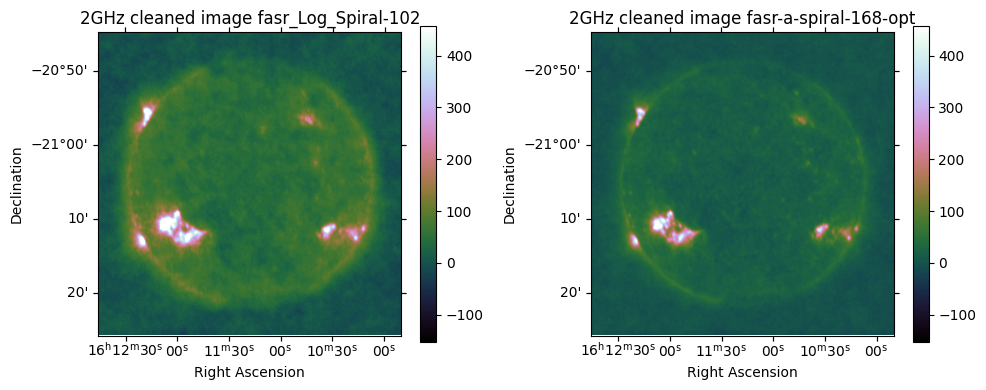

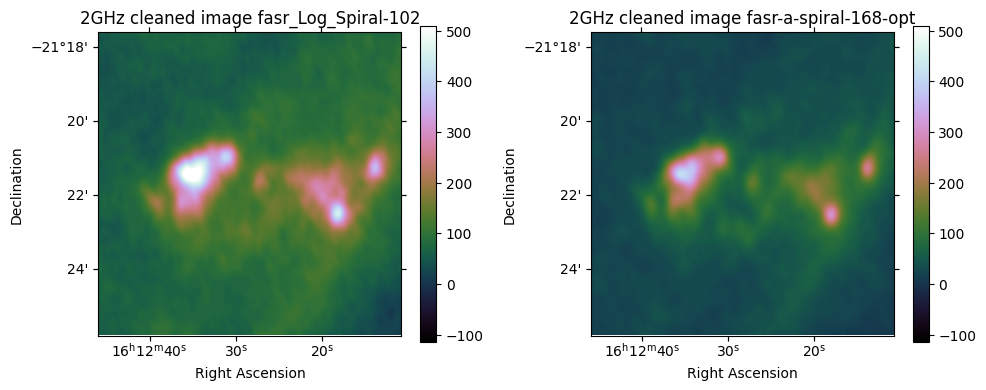

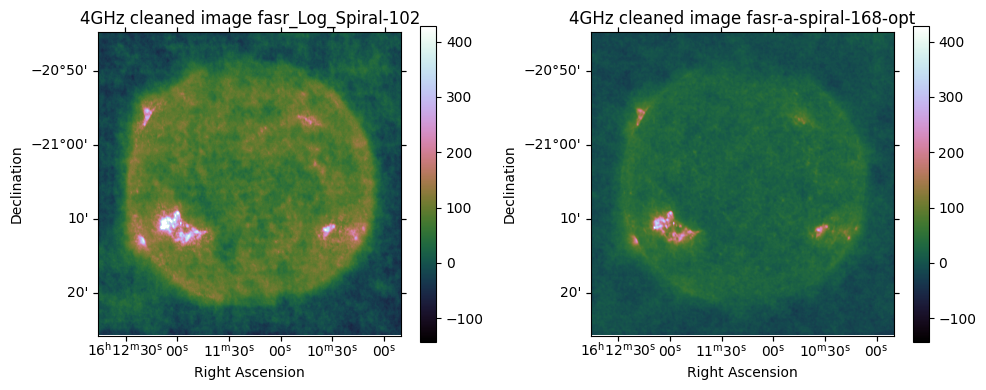

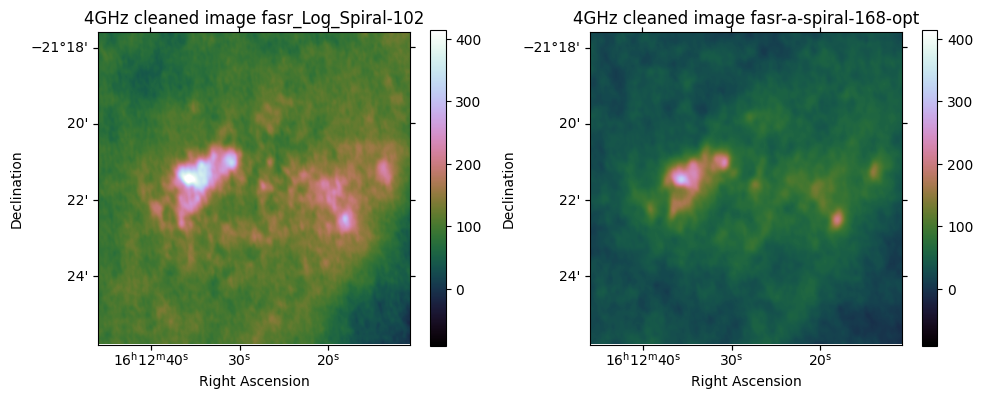

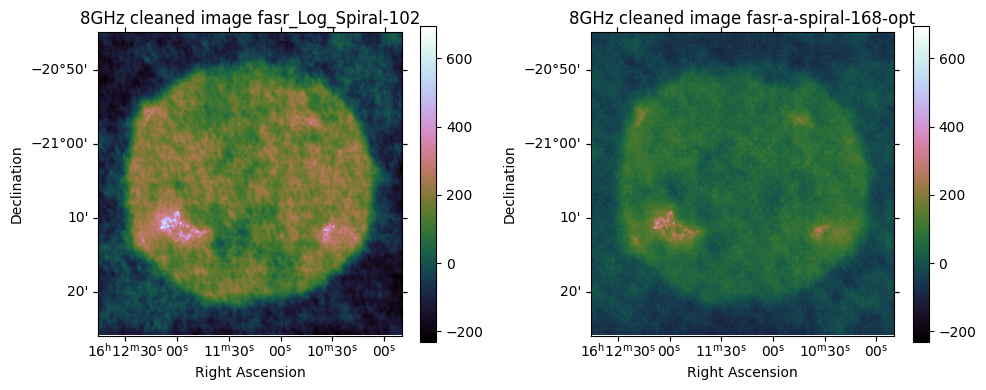

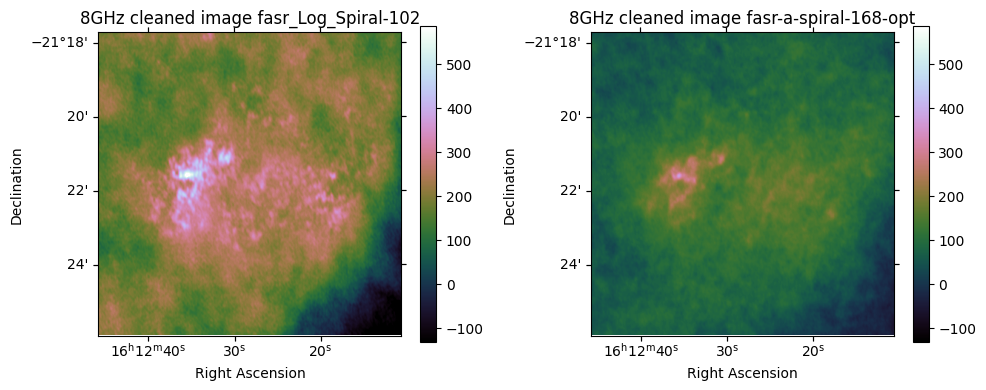

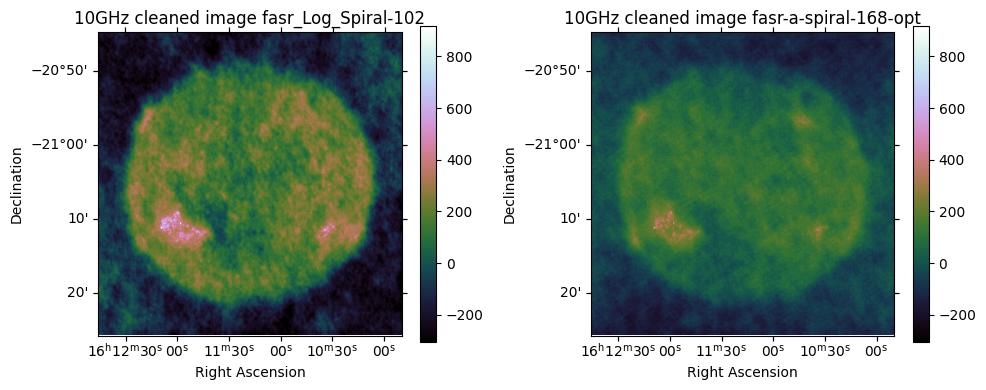

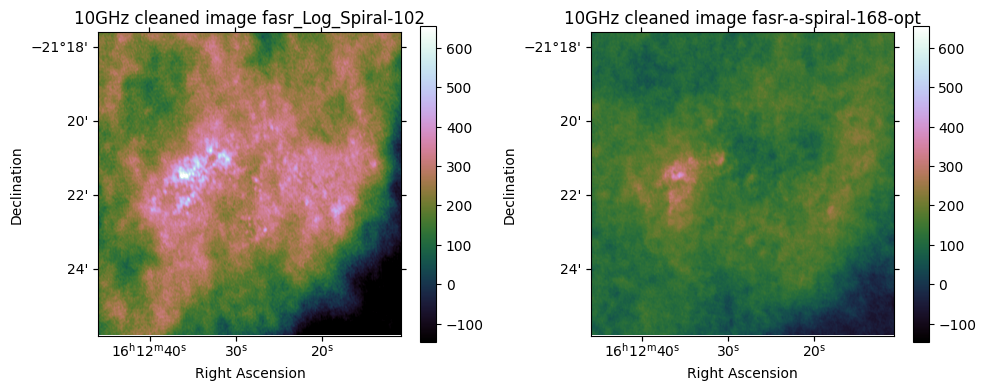

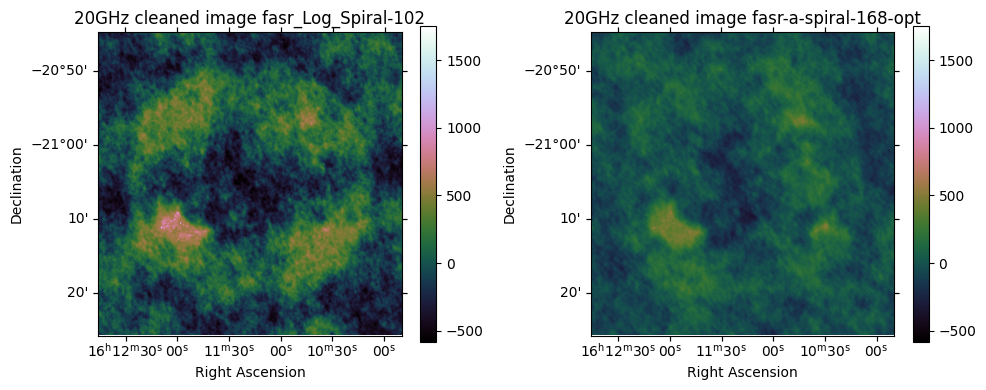

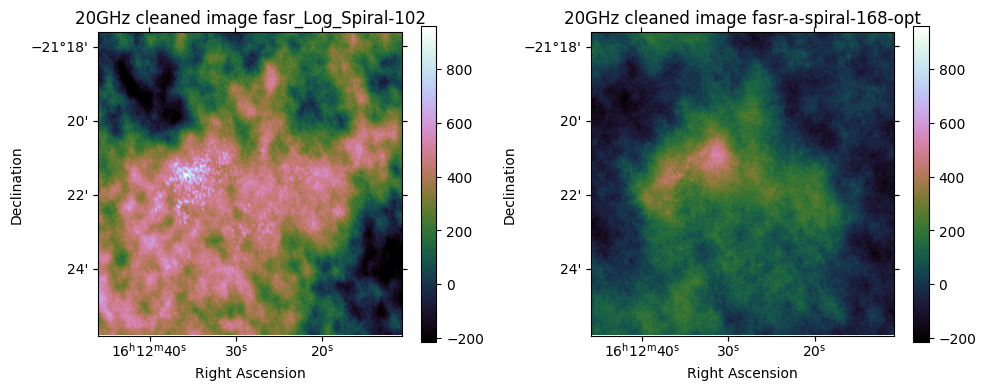

In [46]:
from importlib import reload
project = 'FASR'
reload(fss)
figdir = os.path.join(project,figsubfolder)
for freqstr in ['2GHz', '4GHz', '8GHz', '10GHz', '20GHz']:
    # config_file1 = 'fasr_Log_Spiral-151.cfg'
    # config_file1 = 'fasr_Log_Spiral-168.cfg'
    config_file1 = 'fasr_Log_Spiral-102.cfg'
    cfg_suffix1 = os.path.basename(config_file1.rstrip(".cfg"))
    imname = os.path.join(project,
                          f'fasr_{freqstr}_{reftime_obj.strftime("%Y%m%dT%H%M%SUT")}_{integration_time:0d}s_{cfg_suffix1}')
    image1 = imname + '.image'
    title1 = f'{freqstr} cleaned image {cfg_suffix1}'

    config_file2 = 'fasr-a-spiral-168-opt.cfg'
    cfg_suffix2 = os.path.basename(config_file2.rstrip(".cfg"))
    imname = os.path.join(project,
                          f'fasr_{freqstr}_{reftime_obj.strftime("%Y%m%dT%H%M%SUT")}_{integration_time:0d}s_{cfg_suffix2}')
    image2 = imname + '.image'
    title2 = f'{freqstr} cleaned image {cfg_suffix2}'
    fig, axs = fss.plot_two_casa_images(image1, image2,
                                        crop_fraction=(0.0, 1.0),
                                        figsize=(15, 4),
                                        title1=title1,
                                        title2=title2,
                                        cmap='cubehelix',
                                        vmax=60, vmin=-20,
                                        uni_vmaxmin=True,
                                        compare_two=False,
                                        contour_levels=[0.025, 0.05, 0.1, 0.2, 0.4, 0.8])
    figname = os.path.join(figdir, f'fig-{cfg_suffix1}-{cfg_suffix2}-{freqstr}.jpg')
    fig.savefig(figname, dpi=300)
    fig, axs = fss.plot_two_casa_images(image1, image2,
                                        crop_fraction=((0.69, 0.89), (0.24, 0.44)),
                                        figsize=(15, 4),
                                        title1=title1,
                                        title2=title2,
                                        cmap='cubehelix',
                                        vmax=90, vmin=-20,
                                        uni_vmaxmin=True,
                                        compare_two=False,
                                        contour_levels=[0.025, 0.05, 0.1, 0.2, 0.4, 0.8])
    figname = os.path.join(figdir, f'fig-{cfg_suffix1}-{cfg_suffix2}-{freqstr}-blowup.jpg')
    fig.savefig(figname, dpi=300)

In [957]:
fss.plot_casa_image(imname + '.image', title=f'{freqstr} cleaned image {config_file}', cmap='cubehelix', norm='linear')

<IPython.core.display.Javascript object>

(<Figure size 1000x700 with 2 Axes>,
 <WCSAxes: title={'center': '20GHz cleaned image fasr_Log_Spiral-168.cfg'}>)

(<Figure size 1000x700 with 2 Axes>,
 <WCSAxes: title={'center': '4GHz model (convolved)'}>)

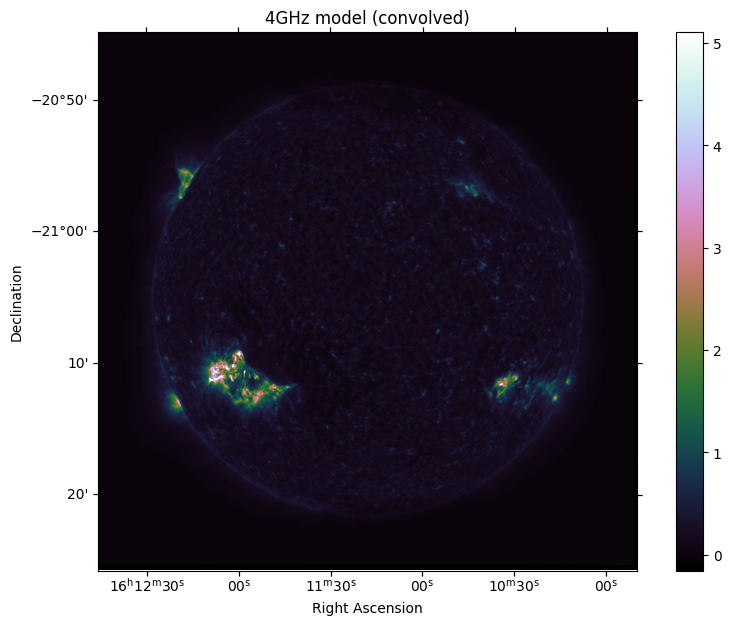

In [135]:
fss.plot_casa_image(os.path.join(project, os.path.basename(solar_model.replace('.fits', '.im'))),
                    title=f'{freqstr} model (convolved)',
                    norm='linear', cmap='cubehelix')